In [1]:
from __future__ import division  
import time  
import numpy as np  
from sklearn.svm import SVR  
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import learning_curve  
import matplotlib.pyplot as plt  
  
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

import pandas as pd
cap = pd.read_csv("/Users/houzhuo/Downloads/capdata3.csv")
robot    = pd.read_csv("/Users/houzhuo/Downloads/robot.csv")
full = pd.concat([cap,robot],axis=1)
full.head()

/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,No,1,2,3,4,5,6,7,8,9,...,Shoulder_L,Hiproll_R,Shoulder_R,Hip,Moe,Hip_R,Head,Shoulder_peach_L,Head_pitch,Shoulder_pitch_R
0,1,-70.2093,77.6512,-2.40005,-30.6520,-70.7097,-18.5101,-1.48789,6.43077,-90.1392,...,-2016.000000,0.000000,2199.000000,0.0,261.000000,0.0,916.000000,1072.0,-271.0,-1028.0
1,2,-70.2093,77.6512,-2.40005,-30.0076,-70.6074,-17.7873,-1.51620,6.45095,-90.1584,...,-2018.228261,-5.869565,2193.141304,0.0,261.608696,0.0,917.586956,1072.0,-271.0,-1028.0
2,3,-70.2093,77.6512,-2.40005,-29.4269,-70.5241,-17.1182,-1.53064,6.46612,-90.1798,...,-2020.456522,-11.739130,2187.282609,0.0,262.217391,0.0,919.173913,1072.0,-271.0,-1028.0
3,4,-70.2093,77.6512,-2.40005,-28.9343,-70.4591,-16.5383,-1.52306,6.47134,-90.2022,...,-2022.684783,-17.608696,2181.423913,0.0,262.826087,0.0,920.760870,1072.0,-271.0,-1028.0
4,5,-70.2093,77.6512,-2.40005,-28.3700,-70.3946,-15.9114,-1.51531,6.47130,-90.2185,...,-2024.913043,-23.478261,2175.565217,0.0,263.434783,0.0,922.347826,1072.0,-271.0,-1028.0


In [2]:
#cap_head = pd.concat(cap_headx,cap_heady,cap_headz)
dataset = pd.concat( [full['76'],full['77'],full['78'],full['Head'] ] , axis=1 )
dataset.head()
type(dataset)

pandas.core.frame.DataFrame

In [10]:
import numpy as np
from sklearn import preprocessing
#values = dataset.values
values = dataset.astype(np.float32)
#values -= np.mean(values, axis = 0)
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, 1, 1)
#time_step=3
#n_features=4
#reframed = series_to_supervised(scaled, time_step, 1)

#scaled
#train_X= dataset[ 0:891 ]

In [28]:
n_features=3
values = dataset.values

min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(values)


train = scaled[:8000,:]
val = scaled[8000:10000]
test = scaled[10000:]




n_obs = n_features
train_X,train_y = train[:,:n_obs],train[:,-1]
val_X,val_y = val[:,:n_obs],val[:,-1]#第一个多少行
test_X,test_y = test[:,:n_obs],test[:,-1]
print(train_X.shape,train_y.shape)

(8000, 3) (8000,)


In [29]:
print(train.shape,train_X,train_y)

(8000, 4) [[0.41278111 0.52601125 0.50802221]
 [0.41812889 0.52942074 0.50977422]
 [0.4217995  0.53171622 0.51098208]
 ...
 [0.65020998 0.62424397 0.42628438]
 [0.64765043 0.62415558 0.43165925]
 [0.6467938  0.62455243 0.43252774]] [0.67820916 0.67876424 0.67931931 ... 0.66210297 0.66176985 0.66176985]


In [41]:
#训练规模  
train_size = 3000  
#初始化SVR  
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.3),verbose=True, cv=5,  
                   param_grid={"C": [1e0, 1e1,1e2,1e3],  
                               "gamma": np.logspace( -2,2, 5)})  
#记录训练时间  
t0 = time.time()  
#训练  
svr.fit(train_X[:train_size], train_y[:train_size])  
svr_fit = time.time() - t0  
  
t0 = time.time()  
#测试  
y_svr = svr.predict(test_X)  
svr_predict = time.time() - t0  

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


In [39]:
#inv_yhat = concatenate((y_svr, test_X[:, -3:]))
inv_yhat = scaler.inverse_transform(train_X)

NameError: name 'scaler' is not defined

/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys
/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


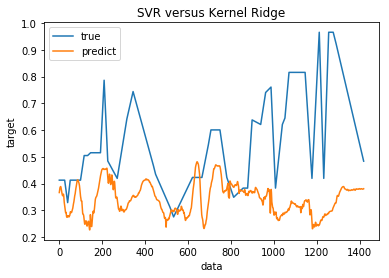

In [42]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# 对结果进行显示  
#plt.scatter(test_X[:500], c='k', label='data', zorder=1)  
plt.hold('on')  
plt.plot(test_y,label='true')  
plt.plot(y_svr,label='predict')
  
plt.xlabel('data')  
plt.ylabel('target')  
plt.title('SVR versus Kernel Ridge')  
plt.legend()  
  
plt.figure()

In [40]:
y_svr

array([0.52270323, 0.52270336, 0.52270411, 0.52270602, 0.5227075 ,
       0.52270823, 0.52271067, 0.52271023, 0.52270508, 0.52270341,
       0.52270323, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270322, 0.52270322,
       0.52270322, 0.52270322, 0.52270322, 0.52270325, 0.52270